In [1]:
import os
import numpy as np
import pandas as pd
import time
import cv2 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path = "../input/cassava-leaf-disease-classification/"
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_img_path = os.path.join(data_path, 'train_images')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


Number of total train data: 21397
Number of total label: 5, Whole label: [0 3 1 2 4]
Ratio of each label:
3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64


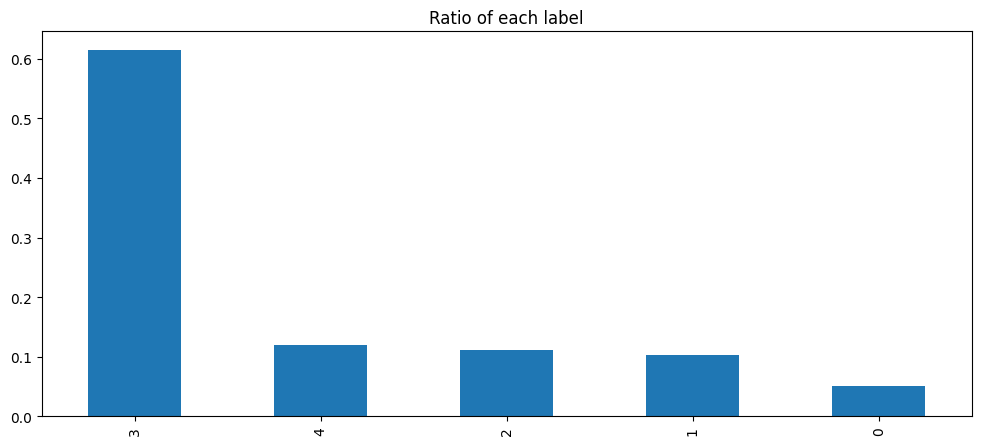

In [3]:
print("Number of total train data: {}".format(len(train_df)))
print("Number of total label: {}, Whole label: {}".format(len(train_df['label'].unique()), train_df['label'].unique()))
print("Ratio of each label:")
print(train_df['label'].value_counts()/len(train_df))

fig = plt.figure(figsize=(12,5))
(train_df['label'].value_counts()/len(train_df)).plot(kind='bar')
plt.title("Ratio of each label")
plt.show()

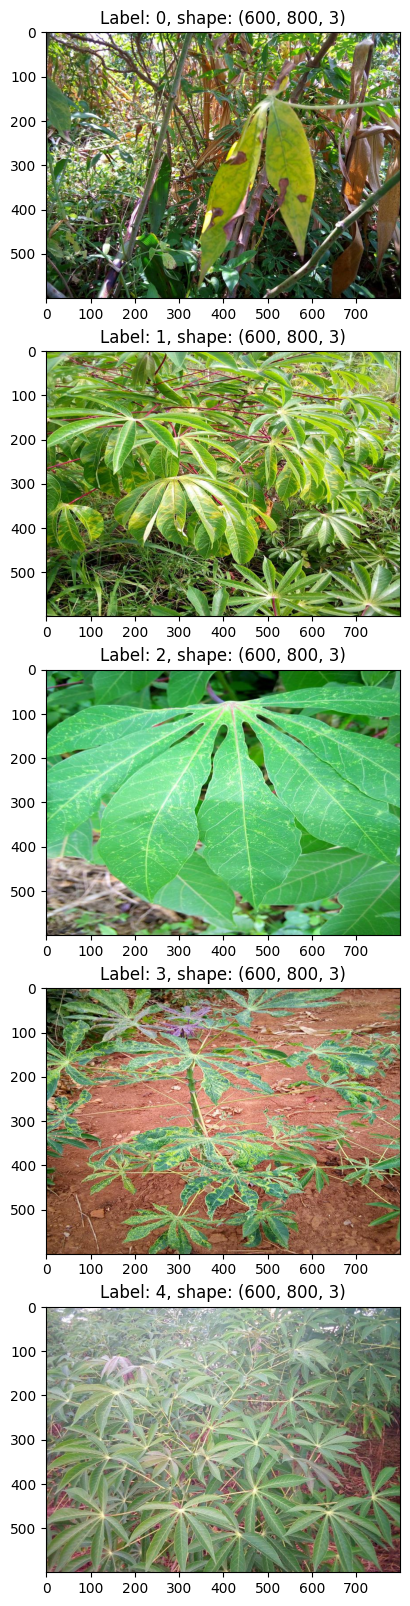

In [4]:
# plot train_data
def plot_images_from_df(df:pd.DataFrame, data_path:str, figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    
    for i in range(len(df['label'].unique())):
        ax = fig.add_subplot(len(df['label'].unique()),1,i+1)
        sample = df[df['label']==i]['image_id'].sample().reset_index(drop=True).iloc[0]
        sample_path = os.path.join(data_path, sample)
        sample_img = cv2.imread(sample_path)
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        plt.imshow(sample_img)
        plt.title("Label: {}, shape: {}".format(i, sample_img.shape))
    plt.show()
    
plot_images_from_df(train_df, train_img_path)

Dataset and Transform Test: -------- 
sample data label: 0


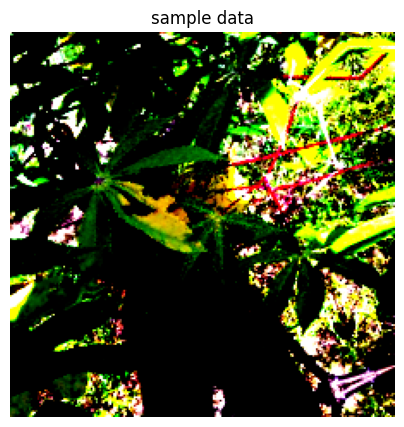

In [5]:
# create Dataset and Transform
class CassavaDataset(Dataset):
    def __init__(self, df:pd.DataFrame, data_img_path:str, phase:str='train', transform:object=None):
        self.df = df
        self.data_img_path = data_img_path
        self.phase = phase
        self.transform = transform
        
    def __getitem__(self, idx):
        sample = self.df['image_id'].iloc[idx]
        sample_img = cv2.imread(os.path.join(self.data_img_path, sample))
        sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            x = transform(self.phase, sample_img)
            
        if self.phase == 'test':
            return x
        
        label = self.df['label'].iloc[idx]
        
        return x, label
    
    def __len__(self):
        return len(self.df)
    
class Transform(object):
    def __init__(self, resize, mean, std):
        self.transform = {
        'train': A.Compose([
                A.Resize(resize,resize),
                A.RandomCrop(224,224, p=1.0),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.Normalize(mean, std),
                A.ShiftScaleRotate(p=0.5),
                ToTensorV2()
            ]),
        'val': A.Compose([
                A.Resize(resize, resize),
                A.RandomCrop(224,224, p=1.0),
                A.Normalize(mean, std),
                ToTensorV2()
            ]),
        'test': A.Compose([
                A.Resize(resize, resize),
                A.RandomCrop(224,224, p=1.0),
                A.Normalize(mean, std),
                ToTensorV2()
            ])  
        }
    
    def __call__(self, phase, x):
        return self.transform[phase](image=x)['image']
    
resize = 256
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = Transform(resize, mean, std)
testdataset = CassavaDataset(train_df, train_img_path, 'train', transform)
data, label = testdataset.__getitem__(0)

print("Dataset and Transform Test: -------- ")
print('sample data label: {}'.format(label))
sample_img = data.numpy()
sample_img = sample_img.transpose((1,2,0))
fig = plt.figure(figsize=(5,5))
plt.imshow(sample_img)
plt.title("sample data")
plt.axis('off')
plt.show()

In [6]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False,
    )


def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size=1, stride=stride, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1  # 出力のチャンネル数を入力のチャンネル数の何倍に拡大するか

    def __init__(
        self,
        in_channels,
        channels,
        stride=1
    ):
        super().__init__()
        self.conv1 = conv3x3(in_channels, channels, stride)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(channels, channels)
        self.bn2 = nn.BatchNorm2d(channels)

        # 入力と出力のチャンネル数が異なる場合、x をダウンサンプリングする。
        if in_channels != channels * self.expansion:
            self.shortcut = nn.Sequential(
                conv1x1(in_channels, channels * self.expansion, stride),
                nn.BatchNorm2d(channels * self.expansion),
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(x)

        out = self.relu(out)

        return out
    
class Bottleneck(nn.Module):
    expansion = 4  # 出力のチャンネル数を入力のチャンネル数の何倍に拡大するか

    def __init__(self, in_channels, channels, stride=1):
        super().__init__()
        self.conv1 = conv1x1(in_channels, channels)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = conv3x3(channels, channels, stride)
        self.bn2 = nn.BatchNorm2d(channels)
        self.conv3 = conv1x1(channels, channels * self.expansion)
        self.bn3 = nn.BatchNorm2d(channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # 入力と出力のチャンネル数が異なる場合、x をダウンサンプリングする。
        if in_channels != channels * self.expansion:
            self.shortcut = nn.Sequential(
                conv1x1(in_channels, channels * self.expansion, stride),
                nn.BatchNorm2d(channels * self.expansion),
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += self.shortcut(x)

        out = self.relu(out)

        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 重みを初期化する。
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, channels, blocks, stride):
        layers = []

        # 最初の Residual Block
        layers.append(block(self.in_channels, channels, stride))

        # 残りの Residual Block
        self.in_channels = channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

model = resnet34()

In [7]:
import time
from tqdm.notebook import tqdm

def train_model(model, dtdl_dict, criterion, optimizer, device, epochs=5, scheduler=None):
    since = time.time()
    best_acc = 0.0
    
    if device == 'cuda':
        model = nn.DataParallel(model)
        torch.backends.cudnn.benchmark = True
    
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs-1))
        print("-"*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dtdl_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase=='train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            if phase == 'train' and scheduler != None:
                scheduler.step()

            epoch_loss = running_loss / len(dtdl_dict[phase].dataset)
            epoch_acc = running_corrects / len(dtdl_dict[phase].dataset)
            
            print("{} Loss: {:.4f}, Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and best_acc < epoch_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_resnet.pth')
            
        print()
    time_elapced = time.time() - since
    print('Trainning complete: {}m {}s'.format(time_elapced//60, time_elapced%60))
    print('Best Val Acc: {}'.format(best_acc))

train, val = train_test_split(train_df, test_size=0.2, random_state=42)
trainDataset = CassavaDataset(train, train_img_path, 'train', transform)
valDataset = CassavaDataset(val, train_img_path, 'val', transform)
train_dl = DataLoader(trainDataset, batch_size=16, shuffle=True, num_workers=2)
val_dl = DataLoader(valDataset, batch_size=16, shuffle=True, num_workers=2)

dtdl_dict = {'train':train_dl, 'val':val_dl}
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5) 
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_model(model, dtdl_dict, criterion, optimizer, device, epochs)

In [14]:
model_path = '../input/baseline-resnet/best_resnet.pth'
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [16]:
test_df = pd.read_csv(data_path + 'sample_submission.csv')
test_img_path = data_path + 'test_images/'
testdataset = CassavaDataset(test_df, test_img_path, 'test', transform)
testdl = DataLoader(testdataset, batch_size=1, shuffle=True)

predictions = []
for inputs in testdl:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    preds = preds.to('cpu')
    predictions.append(preds)

test_df['label'] = np.concatenate(predictions)
test_df.to_csv('submission.csv', index=False)